In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import sklearn

# Principal Component Analysis

In [2]:

def vrow (n):
    return n.reshape(1, n.size)

def vcol (n):
    return n.reshape(n.size, 1)


In [3]:
def load(fname):
    DList = []
    labelsList = []
    hLabels = {
        'Iris-setosa': 0,
        'Iris-versicolor': 1,
        'Iris-virginica': 2
        }

    with open(fname) as f:
        for line in f:
            try:
                attrs = line.split(',')[0:-1]
                attrs = vcol(np.array([float(i) for i in attrs]))
                name = line.split(',')[-1].strip()
                label = hLabels[name]
                DList.append(attrs)
                labelsList.append(label)
            except:
                pass

    return np.hstack(DList), np.array(labelsList, dtype=np.int32)


In [4]:
def pca(D, m):
    mu = D.mean(axis=1)
    #We center the data
    DC = D - vcol(mu)
    C = np.dot(DC, DC.T) / D.shape[1]
    s, U = np.linalg.eigh(C)
    P = U[:, ::-1][:, 0:m]
    return P


In [5]:
#this function is used to project the data
def apply_pca(U, D):
    DP = np.dot(U.T, D)
    return DP

In [6]:
D, L = load("iris.csv")
mu = D.mean(axis=1)
#We center the data
DC = D - vcol(mu)
C = np.dot(DC, DC.T) / D.shape[1]
print("mu : ", mu)
print("covariance matrix : ")
print(C)

mu :  [5.84333333 3.05733333 3.758      1.19933333]
covariance matrix : 
[[ 0.68112222 -0.04215111  1.26582     0.51282889]
 [-0.04215111  0.18871289 -0.32745867 -0.12082844]
 [ 1.26582    -0.32745867  3.09550267  1.286972  ]
 [ 0.51282889 -0.12082844  1.286972    0.57713289]]


In [7]:
#if it was not squared we should have used --> numpy.linalg.eig
#eig does not sort the eigenvalues and eigenvectors, while eigh returns the eigenvalues, sorted from smallest to largest, and the corresponding eigenvector
#eigh is for symmetric matrices
s, U = np.linalg.eigh(C)
print("Eigenvalues : ", s)
print("Eigenvectors : ")
print(U)

Eigenvalues :  [0.02367619 0.0776881  0.24105294 4.20005343]
Eigenvectors : 
[[ 0.31548719  0.58202985  0.65658877 -0.36138659]
 [-0.3197231  -0.59791083  0.73016143  0.08452251]
 [-0.47983899 -0.07623608 -0.17337266 -0.85667061]
 [ 0.75365743 -0.54583143 -0.07548102 -0.3582892 ]]


[[-0.36138659  0.65658877]
 [ 0.08452251  0.73016143]
 [-0.85667061 -0.17337266]
 [-0.3582892  -0.07548102]]


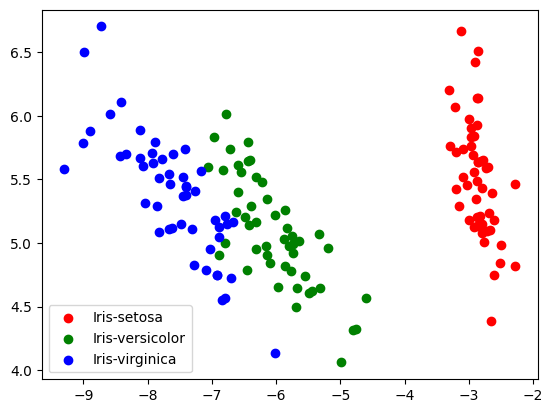

In [8]:

# m is equal 2 because we want to reduce the dimensionality of the data to a 2D space
m = 2
#we also reverse the order of the columns of U so that the leading eigenvectors are in the first m columns
P = U[:, ::-1][:, 0:m]
print(P)
#Since the covariance matrix is semi-definite positive, we can also get the sorted eigenvectors from the Singular Value Decomposition (SVD)
#U, s, Vh = np.linalg.svd(C)
#P = U[:, 0:m]
#print(P)

#Finally, we can apply the projection to a single point x or to a matrix of samples D as --> y = numpy.dot(P.T, x) or Y = numpy.dot(P.T, D)
pca_DP = np.dot(P.T, D)

plt.scatter(pca_DP[0, L == 0], pca_DP[1, L == 0], c='r', label='Iris-setosa')
plt.scatter(pca_DP[0, L == 1], pca_DP[1, L == 1], c='g', label='Iris-versicolor')
plt.scatter(pca_DP[0, L == 2], pca_DP[1, L == 2], c='b', label='Iris-virginica')
plt.legend()
plt.show()

# Linear Discriminant Analysis

#### To compute the LDA transformation matrix W we need to compute the between and within class covariance matrices


In [9]:
def sw_sb_lda(D, L):
    unique_labels  = np.unique(L)
    m = D.mean(axis=1)
    Sb = np.zeros((D.shape[0], D.shape[0]))
    Sw = np.zeros((D.shape[0], D.shape[0]))
    for label in unique_labels :
        Di = D[:, L == label]
        mi = Di.mean(axis=1)
        Sw += np.dot(Di - vcol(mi), (Di - vcol(mi)).T)
        Sb += np.dot(vcol(mi - m), (vcol(mi - m)).T) * Di.shape[1]
    Sb = Sb / D.shape[1]
    Sw = Sw / D.shape[1]
    return Sw, Sb


In [10]:
def dimensionality_reduction(D, L, m):
    SW, SB = sw_sb_lda(D, L)
    s, U = scipy.linalg.eigh(SB, SW)
    W = U[:, ::-1][:, 0:m]
    UW, _, _ = np.linalg.svd(W)
    U = UW[:, 0:m]
    return U

In [11]:
def lda(D, L, m):
    U = dimensionality_reduction(D, L, m)
    P = U[:, 0:m]
    return P

In [12]:
#Finally, we can apply the projection to a single point x or to a matrix of samples D as --> y = numpy.dot(P.T, x) or Y = numpy.dot(P.T, D)
def apply_lda(U, D):
    DP = np.dot(U.T, D)
    return DP

[4.34319983e+00 3.62468515e+00 2.38285961e-14 5.81307486e-17]


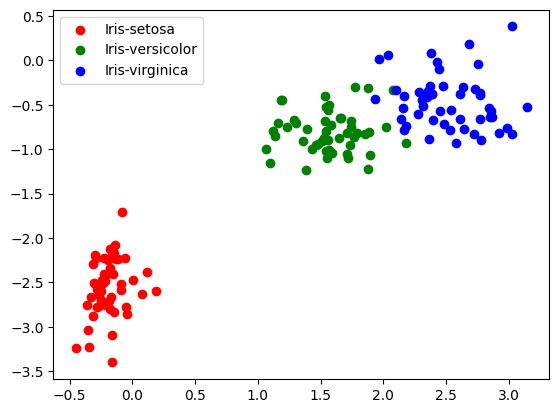

In [13]:
V = np.load('IRIS_LDA_matrix_m2.npy')
#Let U and V be two solutions, with m columns. A quick way to check their
#columns span the same subspace is to check that the matrix [U V ] has m non-zero singular values. You
#can check the singular values as
U = dimensionality_reduction(D, L, 2)
SW, SB = sw_sb_lda(D, L)
print(np.linalg.svd(np.hstack([U, V]))[1])
U = lda(D, L, 2)
DP = apply_lda(U, D)
plt.scatter(DP[0, L == 0], DP[1, L == 0], c='r', label='Iris-setosa')
plt.scatter(DP[0, L == 1], DP[1, L == 1], c='g', label='Iris-versicolor')
plt.scatter(DP[0, L == 2], DP[1, L == 2], c='b', label='Iris-virginica')
plt.legend()
plt.show()

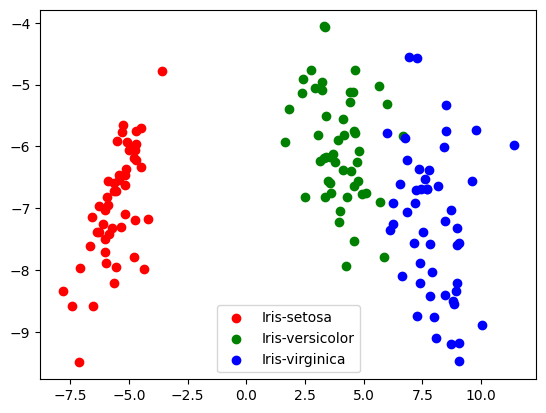

In [14]:
#optional point
U, s, _ = np.linalg.svd(SW)
#We can use np.diag to build a diagonal matrix from a one-dimensional array:
P1 = np.dot( np.dot(U, np.diag(1.0/(s**0.5))), U.T )
SBT = np.dot( np.dot(P1, SB), P1.T )
s, U = np.linalg.eigh(SBT)
P2 = U[:, ::-1][:, 0:m]
W = np.dot(P1.T, P2)
# Project the data using the transformation matrix W
DW = np.dot(W.T, D)

# Plot the projected data
plt.scatter(DW[0, L == 0], DW[1, L == 0], c='r', label='Iris-setosa')
plt.scatter(DW[0, L == 1], DW[1, L == 1], c='g', label='Iris-versicolor')
plt.scatter(DW[0, L == 2], DW[1, L == 2], c='b', label='Iris-virginica')
plt.legend()
plt.show()

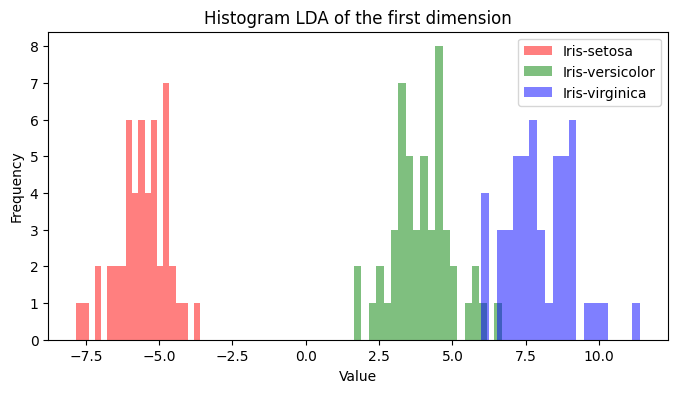

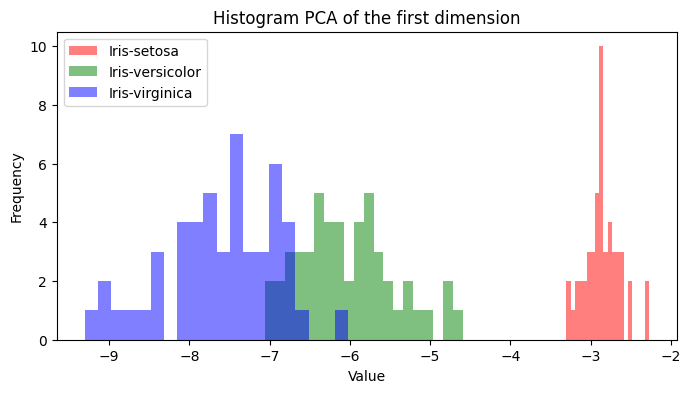

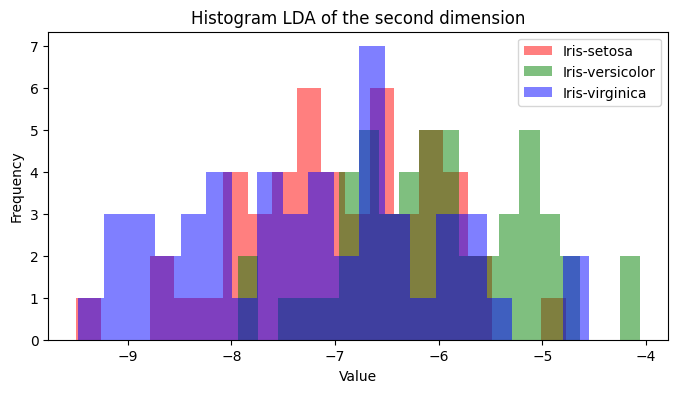

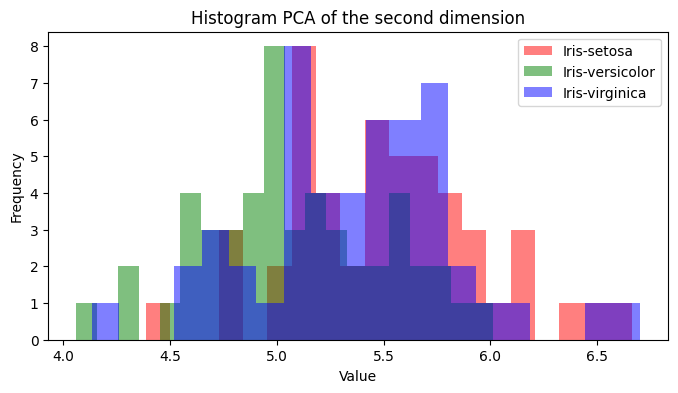

In [15]:
plt.figure(figsize=(8, 4))
plt.hist(DW[0, L == 0], bins=20, alpha=0.5, color='r', label='Iris-setosa')
plt.hist(DW[0, L == 1], bins=20, alpha=0.5, color='g', label='Iris-versicolor')
plt.hist(DW[0, L == 2], bins=20, alpha=0.5, color='b', label='Iris-virginica')
plt.legend()
plt.title('Histogram LDA of the first dimension')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(8, 4))
plt.hist(pca_DP[0, L == 0], bins=20, alpha=0.5, color='r', label='Iris-setosa')
plt.hist(pca_DP[0, L == 1], bins=20, alpha=0.5, color='g', label='Iris-versicolor')
plt.hist(pca_DP[0, L == 2], bins=20, alpha=0.5, color='b', label='Iris-virginica')
plt.legend()
plt.title('Histogram PCA of the first dimension')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(8, 4))
plt.hist(DW[1, L == 0], bins=20, alpha=0.5, color='r', label='Iris-setosa')
plt.hist(DW[1, L == 1], bins=20, alpha=0.5, color='g', label='Iris-versicolor')
plt.hist(DW[1, L == 2], bins=20, alpha=0.5, color='b', label='Iris-virginica')
plt.legend()
plt.title('Histogram LDA of the second dimension')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(8, 4))
plt.hist(pca_DP[1, L == 0], bins=20, alpha=0.5, color='r', label='Iris-setosa')
plt.hist(pca_DP[1, L == 1], bins=20, alpha=0.5, color='g', label='Iris-versicolor')
plt.hist(pca_DP[1, L == 2], bins=20, alpha=0.5, color='b', label='Iris-virginica')
plt.legend()
plt.title('Histogram PCA of the second dimension')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# PCA and LDA for classification
#### We now turn our attention to applications of PCA and LDA, focusing on a binary classification task.

In [16]:
def load_iris():
    return sklearn.datasets.load_iris()['data'].T, sklearn.datasets.load_iris()['target']


In [17]:
#D and L will contain the samples and labels of classes 1 and 2 (versicolor and virginica)
#In this section, we want to apply PCA and LDA to the binary classification problem
DIris, LIris = load_iris()
D = DIris[:, LIris != 0]
L = LIris[LIris != 0]

In [18]:
def split_db_2to1(D, L, seed=0):
    nTrain = int(D.shape[1]*2.0/3.0)
    np.random.seed(seed)
    idx = np.random.permutation(D.shape[1])
    idxTrain = idx[0:nTrain]
    idxTest = idx[nTrain:]
    DTR = D[:, idxTrain]
    DVAL = D[:, idxTest]
    LTR = L[idxTrain]
    LVAL = L[idxTest]

    return (DTR, LTR), (DVAL, LVAL)


In [19]:
# DTR and LTR are model training data and labels
# DVAL and LVAL are validation data and labels
(DTR, LTR), (DVAL, LVAL) = split_db_2to1(D, L)
ULDA = lda(DTR, LTR, 1)
DTR_lda = apply_lda(ULDA, DTR)
if DTR_lda[0, LTR==1].mean() > DTR_lda[0, LTR==2].mean():
        ULDA = -ULDA
        DTR_lda = apply_lda(ULDA, DTR)
        
DVAL_lda = apply_lda(ULDA, DVAL)





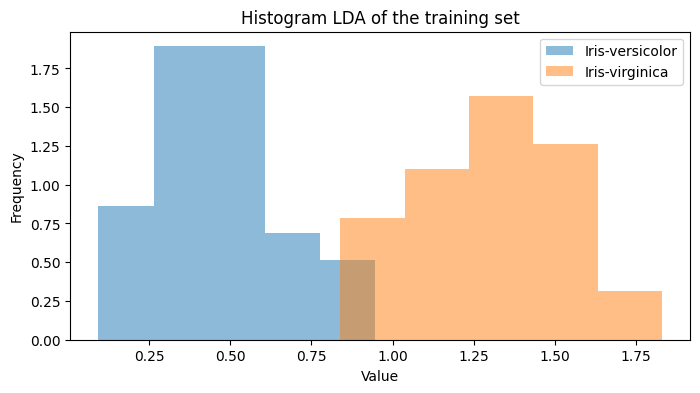

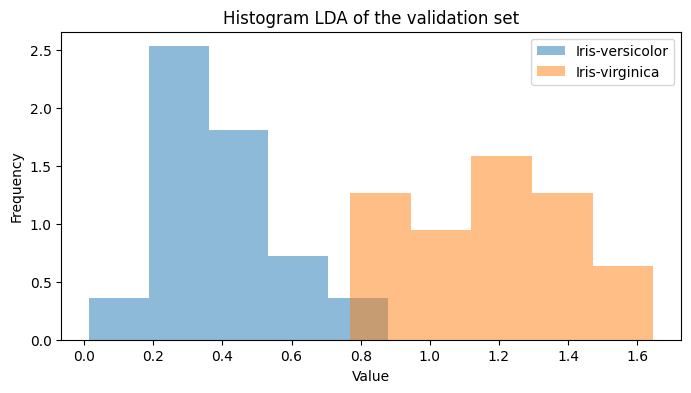

In [20]:
hL = {
    0: 'Iris-setosa',
    1: 'Iris-versicolor',
    2: 'Iris-virginica'
}

plt.figure(figsize=(8, 4))
for label in np.unique(LTR):
    plt.hist(DTR_lda[0, LTR == label], bins=5, alpha=0.5, label=f'{hL[label]}', density=True)
plt.legend()
plt.title('Histogram LDA of the training set')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 4))
for label in np.unique(LVAL):
    plt.hist(DVAL_lda[0, LVAL == label], bins=5, alpha=0.5, label=f'{hL[label]}', density=True)
plt.legend()
plt.title('Histogram LDA of the validation set')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [21]:
#To choose the threshold, for the moment we simply employ the mean of the
#projected class means, computed on the model training data 
threshold = (DTR_lda[0, LTR==1].mean() + DTR_lda[0, LTR==2].mean()) / 2.0 #Projected samples have only 1 dimension
PVAL = np.zeros(shape=LVAL.shape, dtype=np.int32)
PVAL[DVAL_lda[0] >= threshold] = 2
PVAL[DVAL_lda[0] < threshold] = 1

Labels:      [1 2 1 2 1 1 1 2 2 2 1 2 2 2 1 1 2 1 1 2 2 1 2 2 2 1 1 2 1 2 2 2 1 1]
Predictions: [1 2 1 2 1 1 1 2 2 2 2 2 2 2 1 1 2 1 1 2 2 1 2 2 2 1 1 1 1 2 2 2 1 1]
Number of erros: 2 (out of 34 samples)
Error rate: 5.882%
Accuracy :  0.9411764705882353


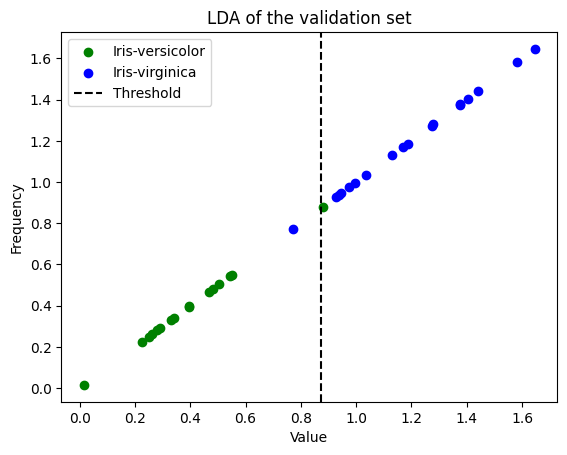

In [22]:
print('Labels:     ', LVAL)
print('Predictions:', PVAL)
print('Number of erros:', (PVAL != LVAL).sum(), '(out of %d samples)' % (LVAL.size))
print('Error rate: %.3f%%' % ( (PVAL != LVAL).sum() / float(LVAL.size) *100 ))
accuracy = np.mean(LVAL == PVAL)
print("Accuracy : ", accuracy)
plt.scatter(DVAL_lda[0, LVAL == 1], DVAL_lda[0, LVAL == 1], c='g', label='Iris-versicolor')
plt.scatter(DVAL_lda[0, LVAL == 2], DVAL_lda[0, LVAL == 2], c='b', label='Iris-virginica')
plt.axvline(x=threshold, color='k', linestyle='--', label='Threshold')
plt.legend()
plt.title('LDA of the validation set')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [23]:
UPCA = pca(DTR, 1)
DTR_pca = apply_pca(UPCA, DTR)
if DTR_pca[0, LTR==1].mean() > DTR_pca[0, LTR==2].mean():
        UPCA = -UPCA
        DTR_pca = apply_pca(UPCA, DTR)
DVAL_pca = apply_pca(UPCA, DVAL)



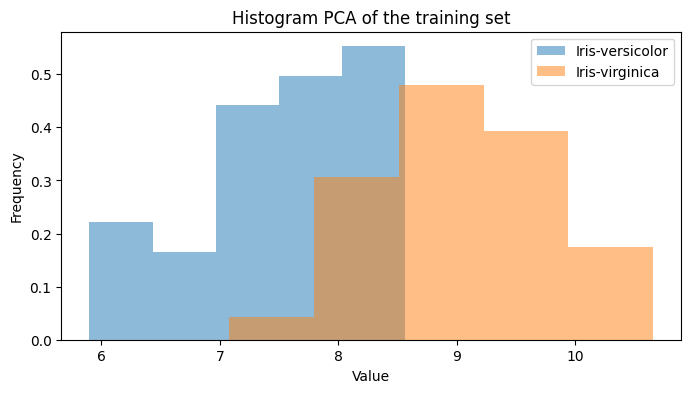

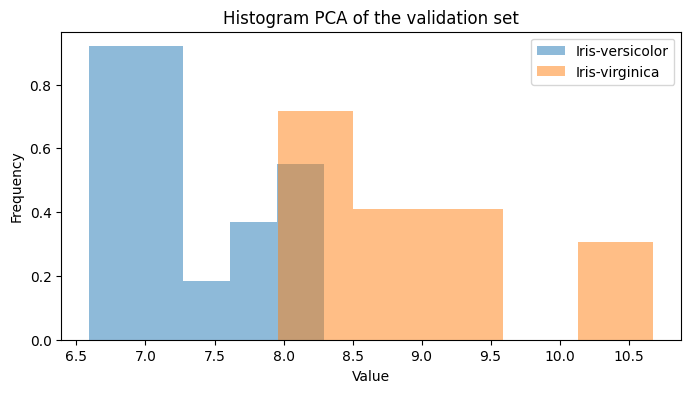

In [24]:

plt.figure(figsize=(8, 4))
for label in np.unique(LTR):
    plt.hist(DTR_pca[0, LTR == label], bins=5, alpha=0.5, label=f'{hL[label]}', density=True)
plt.legend()
plt.title('Histogram PCA of the training set')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 4))
for label in np.unique(LVAL):
    plt.hist(DVAL_pca[0, LVAL == label], bins=5, alpha=0.5, label=f'{hL[label]}', density=True)
plt.legend()
plt.title('Histogram PCA of the validation set')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [25]:
#To choose the threshold, for the moment we simply employ the mean of the
#projected class means, computed on the model training data 
threshold = (DTR_pca[0, LTR==1].mean() + DTR_pca[0, LTR==2].mean()) / 2.0 #Projected samples have only 1 dimension
PVAL = np.zeros(shape=LVAL.shape, dtype=np.int32)
PVAL[DVAL_pca[0] >= threshold] = 2
PVAL[DVAL_pca[0] < threshold] = 1

Labels:      [1 2 1 2 1 1 1 2 2 2 1 2 2 2 1 1 2 1 1 2 2 1 2 2 2 1 1 2 1 2 2 2 1 1]
Predictions: [1 2 1 2 1 1 1 2 2 1 1 2 2 1 1 1 2 1 1 2 2 1 1 2 2 2 1 2 1 2 2 2 1 1]
Number of erros: 4 (out of 34 samples)
Error rate: 11.765%
Accuracy :  0.8823529411764706


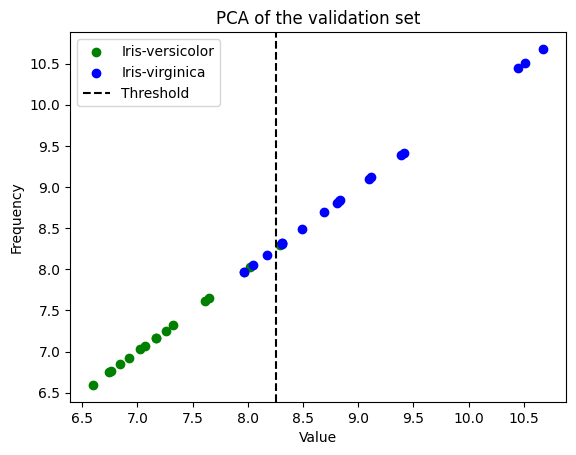

In [26]:
print('Labels:     ', LVAL)
print('Predictions:', PVAL)
print('Number of erros:', (PVAL != LVAL).sum(), '(out of %d samples)' % (LVAL.size))
print('Error rate: %.3f%%' % ( (PVAL != LVAL).sum() / float(LVAL.size) *100 ))
accuracy = np.mean(LVAL == PVAL)
print("Accuracy : ", accuracy)
plt.scatter(DVAL_pca[0, LVAL == 1], DVAL_pca[0, LVAL == 1], c='g', label='Iris-versicolor')
plt.scatter(DVAL_pca[0, LVAL == 2], DVAL_pca[0, LVAL == 2], c='b', label='Iris-virginica')
plt.axvline(x=threshold, color='k', linestyle='--', label='Threshold')
plt.legend()
plt.title('PCA of the validation set')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [27]:
UPCA = pca(DTR, 3) 
DTR_pca = apply_pca(UPCA, DTR)   
DVAL_pca = apply_pca(UPCA, DVAL) 

ULDA = lda(DTR_pca, LTR, 1)

DTR_lda = apply_lda(ULDA, DTR_pca)   
if DTR_lda[0, LTR==1].mean() > DTR_lda[0, LTR==2].mean():
        ULDA = -ULDA
        DTR_lda = apply_lda(ULDA, DTR_pca)

DVAL_lda = apply_lda(ULDA, DVAL_pca) # Applied to PCA-transformed validation data


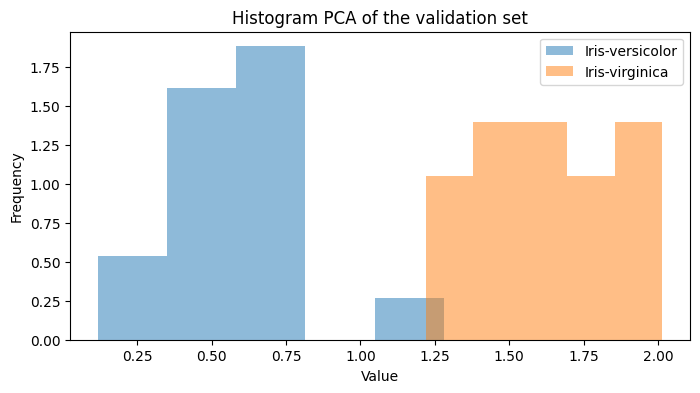

In [28]:

plt.figure(figsize=(8, 4))
for label in np.unique(LVAL):
    plt.hist(DVAL_lda[0, LVAL == label], bins=5, alpha=0.5, label=f'{hL[label]}', density=True)
plt.legend()
plt.title('Histogram PCA of the validation set')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [29]:
#To choose the threshold, for the moment we simply employ the mean of the
#projected class means, computed on the model training data 
threshold = (DTR_lda[0, LTR==1].mean() + DTR_lda[0, LTR==2].mean()) / 2.0 #Projected samples have only 1 dimension
PVAL = np.zeros(shape=LVAL.shape, dtype=np.int32)
PVAL[DVAL_lda[0] >= threshold] = 2
PVAL[DVAL_lda[0] < threshold] = 1

Labels:      [1 2 1 2 1 1 1 2 2 2 1 2 2 2 1 1 2 1 1 2 2 1 2 2 2 1 1 2 1 2 2 2 1 1]
Predictions: [1 2 1 2 1 1 1 2 2 2 2 2 2 2 1 1 2 1 1 2 2 1 2 2 2 1 1 1 1 2 2 2 1 1]
Number of erros: 2 (out of 34 samples)
Error rate: 5.882%
Accuracy :  0.9411764705882353


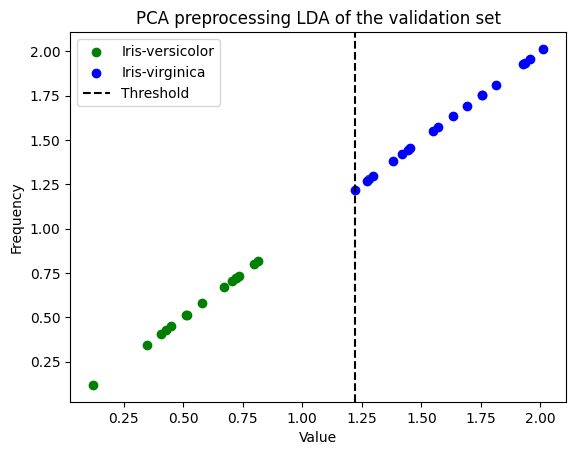

In [30]:
print('Labels:     ', LVAL)
print('Predictions:', PVAL)
print('Number of erros:', (PVAL != LVAL).sum(), '(out of %d samples)' % (LVAL.size))
print('Error rate: %.3f%%' % ( (PVAL != LVAL).sum() / float(LVAL.size) *100 ))
accuracy = np.mean(LVAL == PVAL)
print("Accuracy : ", accuracy)
plt.scatter(DVAL_lda[0, LVAL == 1], DVAL_lda[0, LVAL == 1], c='g', label='Iris-versicolor')
plt.scatter(DVAL_lda[0, LVAL == 2], DVAL_lda[0, LVAL == 2], c='b', label='Iris-virginica')
plt.axvline(x=threshold, color='k', linestyle='--', label='Threshold')
plt.legend()
plt.title('PCA preprocessing LDA of the validation set')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()